In [5]:
import yfinance as yf
import talib
import mplfinance as mpf

from financeanalysis.utils import crossing2ma, detection_support_resistance_lvl, get_last_weekday_date, resample_weekly2daily

today_date = get_last_weekday_date()

### Download data, with 3 different TimeFrame -> 1h, 1d, 1w

In [6]:
tiker = 'SPY'
tf_1h = yf.download(tiker, period='1y', interval='1h')
tf_1d = yf.download(tiker, interval='1d')
tf_1w = yf.download(tiker, interval='1wk')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted


### Data preparation

In [7]:
tf_1w['SMA_200_W'] = talib.SMA(tf_1w['Close'], timeperiod=200)

tf_1d['SMA_200_D'] = talib.SMA(tf_1d['Close'], timeperiod=200)
tf_1d['MACD'], tf_1d['MACD_SIGNAL'], _ = talib.MACD(tf_1d['Close'])
cross_macd_mask = crossing2ma(tf_1d['MACD'], tf_1d['MACD_SIGNAL'])
tf_1d['MACD_CROSS'] = (tf_1d[cross_macd_mask]['MACD'] + tf_1d[cross_macd_mask]['MACD_SIGNAL']) / 2
tf_1d['MACD_MIDDLE'] = 0.000
tf_1d = resample_weekly2daily(tf_1d, tf_1w, "SMA_200_W")

tf_1h['RSI'] = talib.RSI(tf_1h['Close'])
tf_1h['RSI_UP'], tf_1h['RSI_DOWN'] = 70, 30
tf_1h['SMA_20_H'] = talib.SMA(tf_1h['Close'], timeperiod=20)
tf_1h['SMA_50_H'] = talib.SMA(tf_1h['Close'], timeperiod=50)
cross_sma_mask = crossing2ma(tf_1h['SMA_20_H'], tf_1h['SMA_50_H'])
tf_1h['SMA_CROSS_H'] = (tf_1h[cross_sma_mask]['SMA_20_H'] + tf_1h[cross_sma_mask]['SMA_50_H']) / 2
tf_1h.tail()

Exception: inputs are all NaN

### Calculation Supports and Resistances Levels

In [ ]:
SR_Levels_D = detection_support_resistance_lvl(tf_1d['Close'][-150:], k=4)
SR_Levels_H = detection_support_resistance_lvl(tf_1h['Close'][-300:], k=3)

### Plotting Chart with indicators

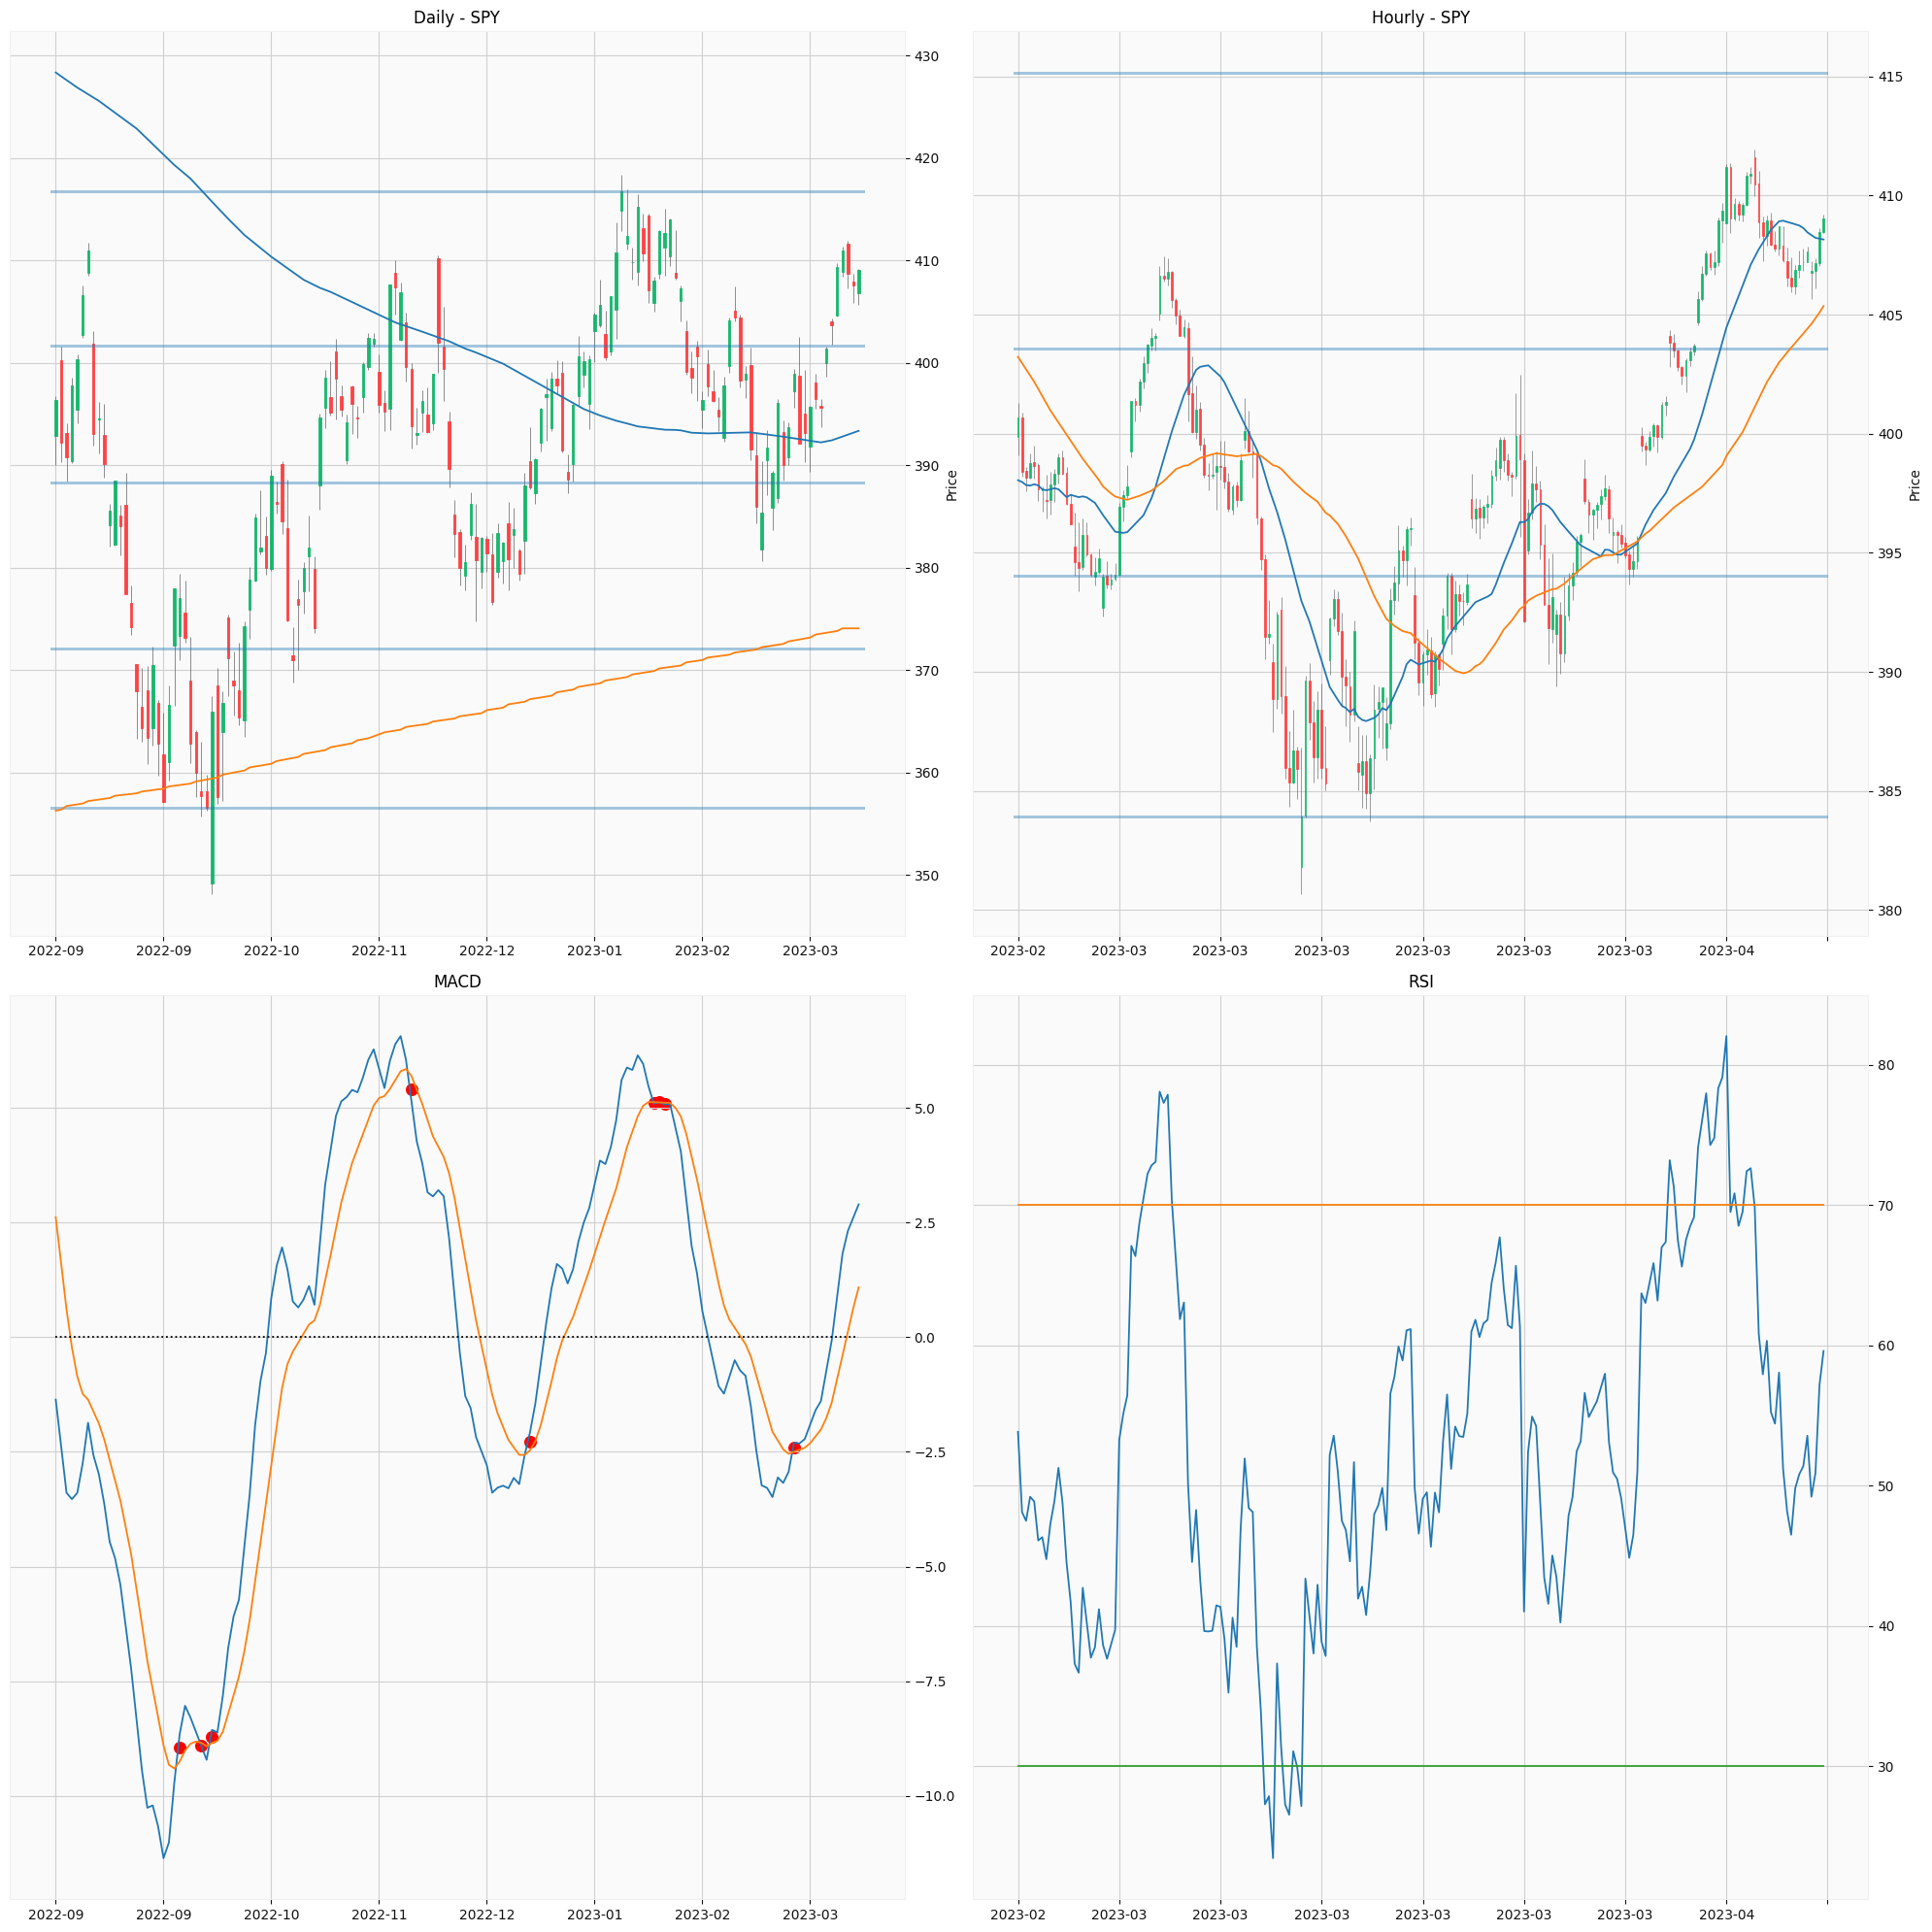

In [ ]:
fig = mpf.figure(figsize=(20,20), style='yahoo', tight_layout=True)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,4, sharex=ax2)
ax4 = fig.add_subplot(2,2,3, sharex=ax1)

d_indicator = [mpf.make_addplot(tf_1d[['MACD', 'MACD_SIGNAL']][-150:], title='MACD', ax=ax4, secondary_y=False),
    mpf.make_addplot(tf_1d['MACD_MIDDLE'][-150:], secondary_y=False, linestyle='dotted', ax=ax4, color='black'),
    mpf.make_addplot(tf_1d['MACD_CROSS'][-150:], type='scatter', ax=ax4, marker='o', markersize=70, color='r', secondary_y=False),
    mpf.make_addplot(tf_1d[['SMA_200_D']][-150:], ax=ax1),
    mpf.make_addplot(tf_1d[['SMA_200_W']][-150:], ax=ax1),
    ]
mpf.plot(tf_1d[-150:],type='candle',ax=ax1,axtitle=f'Daily - {tiker}',xrotation=0, datetime_format='%Y-%m', addplot=d_indicator, hlines=dict(hlines=SR_Levels_D, linewidths=2, alpha=0.4))

h_indicator = [mpf.make_addplot(tf_1h[['RSI', 'RSI_UP', 'RSI_DOWN']][-200:], title='RSI', ax=ax3),
               mpf.make_addplot(tf_1h[['SMA_20_H', 'SMA_50_H']][-200:], ax=ax2),]
mpf.plot(tf_1h[-200:],type='candle', ax=ax2, axtitle=f'Hourly - {tiker}', addplot=h_indicator, xrotation=0, datetime_format='%Y-%m', hlines=dict(hlines=SR_Levels_H, linewidths=2, alpha=0.4))


# fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax3.yaxis.set_label_position('right')
ax3.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax4.yaxis.tick_right()
fig.savefig(f'{tiker}_{today_date}.png')